In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.anova as sma
import numpy as np
from scipy.stats import pearsonr
import pingouin as pg
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")
plt.rcParams['svg.fonttype'] = 'none'



# Functions

In [65]:
# ------------------------------------------------------------------------------------------------------------
# Cleaning functions
# ------------------------------------------------------------------------------------------------------------

def get_max_payoff(f1, f2, cost1=0, cost2=0):
    """
    TODO: clean this up (check it works)
    """
    # data = np.zeros((11-cost2, 11-cost1))
    # for i in range(11-cost1):
        # for j in range(11-cost2):
            # data[j, i] = 10 - i - cost1 + ((i*f1 + j*f2)/2)
    # same algorithm as above but vectorized
    #data = 10 - np.arange(11-cost1) - cost1 + ((np.arange(11-cost1)[:, None]*f1 + np.arange(11-cost2)[None, :]*f2)/2)
    # Create arrays of indices
    i, j = np.indices((int(11-cost1), int(11-cost2)))

    # Compute data array
    data = 10 - i - cost1 + ((i*f1 + j*f2)/2)

    # Transpose data array to match original code
    data = data.T

    return np.amax(data), np.amin(data)


def normalize_payoff(df, with_group, cost=0):
    """
    TODO: clean this up
    """
    f1 = df['multiplier'].unique()[0]
    f2 = df['multiplier'].unique()[1]
    # matching = {}
    # for m1, m2 in ((f1, f2), (f1, f1), (f2, f1), (f2, f2)):
        # matching[(m1, m2)] = {'max': {f1: get_max_payoff(m1, m2, cost)[0], f2: get_max_payoff(m2, m1, cost)[0]},
                            #   'min': {f1: get_max_payoff(m1, m2, cost)[1], f2: get_max_payoff(m2, m1, cost)[1]}}
    
    def func_f1(x):
        # print(x)
        # print('min=', get_max_payoff(x.multiplier, x.opp_multiplier, cost*x.disclose, cost*x.opp_disclose)[1])
        # print('max=', get_max_payoff(x.multiplier, x.opp_multiplier, cost*x.disclose, cost*x.opp_disclose)[0])
        return (x.payoff - get_max_payoff(x.multiplier, x.opp_multiplier, cost*x.disclose, cost*x.opp_disclose)[1]) / \
        (get_max_payoff(x.multiplier, x.opp_multiplier, cost*x.disclose, cost*x.opp_disclose)[0] - \
        get_max_payoff(x.multiplier, x.opp_multiplier, cost*x.disclose, cost*x.opp_disclose)[1])
    
    def func_f2(x):
        return (x.opp_payoff - get_max_payoff(x.opp_multiplier, x.multiplier, cost*x.opp_disclose, cost*x.disclose)[1]) / \
        (get_max_payoff(x.opp_multiplier, x.multiplier, cost*x.opp_disclose, cost*x.disclose)[0] - \
        get_max_payoff(x.opp_multiplier, x.multiplier, cost*x.opp_disclose, cost*x.disclose)[1])
    
    def func_f3(x):
        # print(x)
        opp = get_opp(df, x.group_id, x.name)
        max_, min_ = get_max_payoff(x.multiplier,
         opp.multiplier.values[0], cost*x.disclose, cost*opp.disclose.values[0])

        # x1 = (x.payoff - get_max_payoff(x.multiplier, opp.multiplier, cost*x.disclose, cost*opp.disclose)[1]) / \
        # (get_max_payoff(x.multiplier, opp.multiplier, cost*x.disclose, cost*opp.disclose)[0] - \
        # get_max_payoff(x.multiplier, opp.multiplier, cost*x.disclose, cost*opp.disclose)[1])
        return (x.payoff - min_) / (max_ - min_)
    
    #norm = lambda x: (x - min) / (max - min)
    if with_group:
        df['norm_payoff'] = df.apply(func=func_f3, axis=1)
        # df['avg_norm_payoff'] = (df['norm_payoff'] + df['opp_norm_payoff']) / 2
    else:
        df['norm_payoff'] = df.apply(func=func_f1, axis=1)
        df['opp_norm_payoff'] = df.apply(func=func_f2, axis=1)
        df['avg_norm_payoff'] = (df['norm_payoff'] + df['opp_norm_payoff']) / 2
    return df

    
def get_opp(df, group_id, idx):
    return df[df['group_id'] == group_id].drop(idx)

def add_max_payoff(df, cost=None, with_group=True):
    if with_group:
        group_ids = df['group_id'].unique()
    f1, f2 = sorted(df['multiplier'].unique())
    df['max_payoff'] = np.NaN
    matching = {}
    for m1, m2 in ((f1, f2), (f1, f1), (f2, f1), (f2, f2)):
        matching[(m1, m2)] = [get_max_payoff(m1, m2), get_max_payoff(m2, m1)]

    if not with_group:
        for i, d in df.iterrows():
            t1 = d['multiplier']
            t2 = d['opp_multiplier']
            c1 = int(d['disclose'])
            c2 = int(d['opp_disclose'])

            max_payoff = matching[t1, t2]

            if cost:
                max_payoff = [get_max_payoff(t1, t2, cost1=cost*c1, cost2=c2*cost),
                              get_max_payoff(t2, t1, cost1=cost*c2, cost2=c1*cost)]

            df.loc[i, 'max_payoff'] = max_payoff[0]
            df.loc[i, 'opp_max_payoff'] = max_payoff[1]
        return df 


    for g in group_ids:
        d = df[df['group_id'] == g]
        if len(d) == 2:
            idx = d.index.tolist()
            t1 = d.iloc[0]['multiplier']
            t2 = d.iloc[1]['multiplier']
            c1 = d.iloc[0]['disclose']
            c2 = d.iloc[1]['disclose']

            max_payoff = matching[t1, t2]

            if cost:
                max_payoff = [get_max_payoff(t1, t2, cost1=cost*c1, cost2=c2*cost),
                              get_max_payoff(t2, t1, cost1=cost*c2, cost2=c1*cost)]

            df.loc[idx[0], 'max_payoff'] = max_payoff[0]
            df.loc[idx[1], 'max_payoff'] = max_payoff[1]
    return df


def add_norm_payoff(df, with_opp):
    df['norm_payoff'] = df['payoff']/df['max_payoff']
    if with_opp:
        df['opp_norm_payoff'] = df['opp_payoff']/df['opp_max_payoff']
    return df

def add_norm_contribution(df, cost):
    df['norm_contribution'] = df['contribution']/(10 - df['disclose']*cost)
    return df


def remove_bots(df, threshold=None):
    if threshold:
        ids = df[df.rt1!=-1].prolific_id.unique()
        groups = df[df.prolific_id.isin(ids)].group_id
        df2 = df[df.group_id.isin(groups)].groupby('prolific_id', as_index=False).rt1.value_counts(normalize=True)
        df2.rt1 = df2.rt1.apply(lambda x: 'bot' if x==-1 else 'human')
        df2 = df2.groupby(['prolific_id', 'rt1'], as_index=False).sum()
        return df[df.prolific_id.isin(df2[((df2.rt1 == 'bot') & (df2.proportion<threshold)) | ((df2.rt1=='human') & (df2.proportion>.8))].prolific_id)]

    prolific_id_to_exclude = df[df['rt1'] == -1]['prolific_id'].unique()
    df = df[~df['prolific_id'].isin(prolific_id_to_exclude)]
    return df


def add_subjects(df, num):
    df['id_in_session'] = df['id_in_session'] + (num*100)
    return df


def remove_bots_but_keep_previous_rows(df):
    return df[df['rt1'] != -1]


def remove_trials_where_both_players_are_bots(df):
    group_ids = df['group_id'].unique()
    for g in group_ids:
        d = df[df['group_id'] == g]
        idx = d.index.tolist()
        rt1 = d.iloc[0]['rt1'] == -1
        rt2 = d.iloc[1]['rt1'] == -1
        if rt1 and rt2:
            df = df.drop(idx)
    return df


def remove_incomplete_sub(df, n):
    count = 0
    for i in df['prolific_id'].unique():
        count += len(df[df['prolific_id'] == i]) == n
    # exclude prolific ids with incomplete data (!= n)
    df = df[df.prolific_id.isin(
        df.prolific_id.value_counts()[df.prolific_id.value_counts() == n].index)]
    return df, count

def add_social_welfare(df):
    df['social_welfare'] = df['payoff'] + df['opp_payoff']
    return df


In [130]:
get_max_payoff(2.5, 1.5, 2, 2)
10 - 2 - 8 +  ((2.5*8+ 1.5*8)/2)

(16.0, 8.0)

16.0

# Data clearning

In [80]:
exp = [
    'data/' + f for f in
    ['theresa_sorting.csv',
     'theresa_control.csv',
     'theresa_with_cost.csv',
     'theresa_single.csv',
     'cost_single_final_58.csv',
     ]
]

dfs = [pd.read_csv(f) for f in exp]

for i, d in enumerate(dfs):
   print('Start treating Exp. ', i)
   if i in [3, 4]:
      dfs[i] = remove_bots(dfs[i].copy())
   # if i in [0, 1, 2]:
      # dfs[i] = remove_trials_where_both_players_are_bots(dfs[i].copy())

   dfs[i], count = remove_incomplete_sub(
        df=dfs[i].copy(), n=63 if i in [3, 4] else 60)
   dfs[i] = add_norm_contribution(df=dfs[i].copy(), cost= 2 if i in [2, 4] else 0)
#    dfs[i] = add_max_payoff(df=dfs[i].copy(), cost=2 if i in [2, 4] else None, with_group=not i in [3,4])
#    dfs[i] = add_norm_payoff(df=dfs[i].copy(), with_opp= i in [3, 4])
   # if i in [3, 4]:
   dfs[i] = normalize_payoff(dfs[i].copy(), with_group= i not in [3, 4], cost=2 if i in [2, 4] else 0)
   # if i in [3, 4]:
      # dfs[i] = add_social_welfare(dfs[i].copy())
   
   dfs[i] = dfs[i][dfs[i].round_number>3].copy()
   dfs[i]['exp'] = i

   if i in [0, 1, 2]:
      # TODO: do something about this!!!!
      dfs[i] = dfs[i][dfs[i].disclose!=-1].copy()
      # dfs[i] = remove_bots(dfs[i].copy(), threshold=0.25)
   print(f'Exp {i}', f'N={count}', f'filename={exp[i]}')

full = pd.concat(dfs)
# df = pd.read_csv('data/cost_single_final_58.csv')
    # df['prolific_id']

#

Start treating Exp.  0
Exp 0 N=36 filename=data/theresa_sorting.csv
Start treating Exp.  1
Exp 1 N=30 filename=data/theresa_control.csv
Start treating Exp.  2
Exp 2 N=30 filename=data/theresa_with_cost.csv
Start treating Exp.  3
Exp 3 N=56 filename=data/theresa_single.csv
Start treating Exp.  4
Exp 4 N=46 filename=data/cost_single_final_58.csv


# Check sanity of the data

In [75]:
# check proportions of bots meeting per prolific_id
df = dfs[1].copy()
ids = df[df.rt1!=-1].prolific_id.unique()
groups = df[df.prolific_id.isin(ids)].group_id
df2 = df[df.group_id.isin(groups)].groupby('prolific_id', as_index=False).rt1.value_counts(normalize=True)
df2.rt1 = df2.rt1.apply(lambda x: 'bot' if x==-1 else 'human')

df2.groupby(['prolific_id', 'rt1'], as_index=False).sum()
# plt.title('Distribution of bots per prolific_id')
# plt.xlabel('proportion of bot trials')
# plt.ylabel('subject count')

,prolific_id,rt1,proportion
0,5702c03e68c641000e0d754d,human,1.000000
1,5c573e54e9813700018acc31,bot,0.770833
2,5c573e54e9813700018acc31,human,0.229167
3,5d1a69d8f97a18001977e0d7,human,1.000000
4,5da9b30a3624c200157bd9f0,bot,0.181818
5,5da9b30a3624c200157bd9f0,human,0.818182
6,5dc5c4b99e40c94387aeb4e5,human,1.000000
7,5df3a70877f865293e86c0a0,bot,1.000000
8,5e9c29a39c157d14227afac8,human,1.000000
9,5ea936e503a71a000af12d7b,human,1.000000


/tmp/ipykernel_130354/3926077069.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fig1 = df.groupby('prolific_id').mean().multiplier.plot(kind='hist')
/tmp/ipykernel_130354/3926077069.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('prolific_id', as_index=True).mean().multiplier.value_counts()


1.5    25
2.5    21
Name: multiplier, dtype: int64

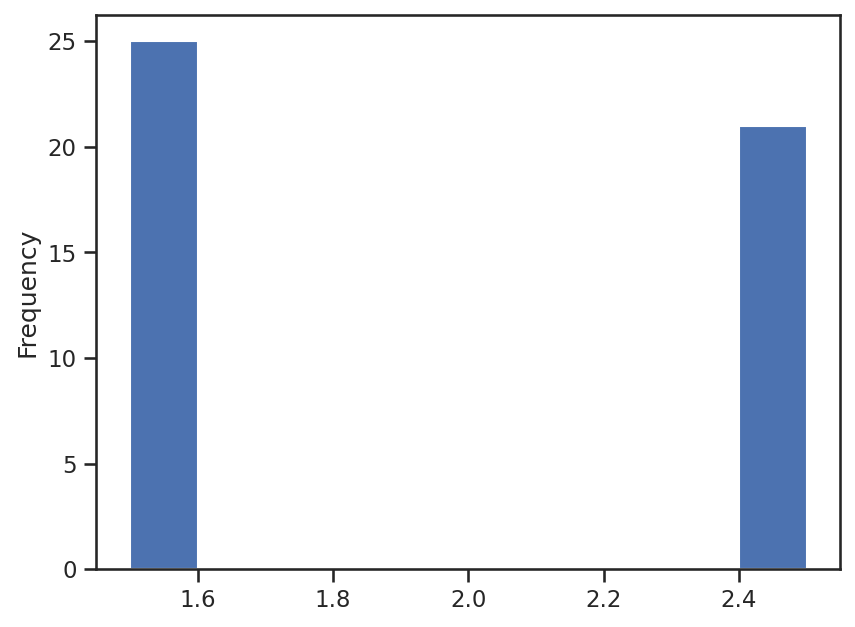

/tmp/ipykernel_130354/3926077069.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('prolific_id').mean().opp_multiplier.value_counts()


2.0    46
Name: opp_multiplier, dtype: int64

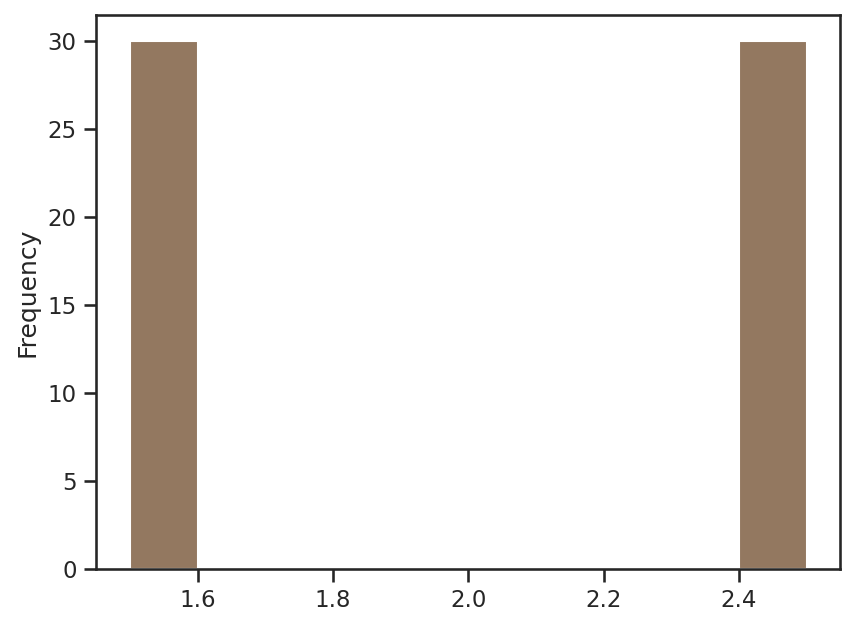

<Axes: xlabel='round_number', ylabel='opp_multiplier'>

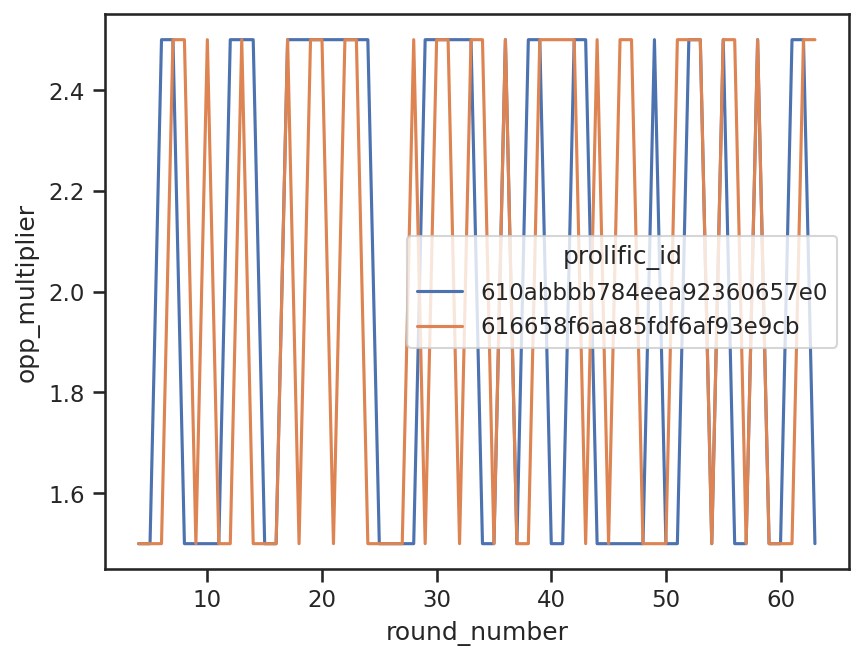

<Axes: xlabel='round_number', ylabel='opp_p_disclose'>

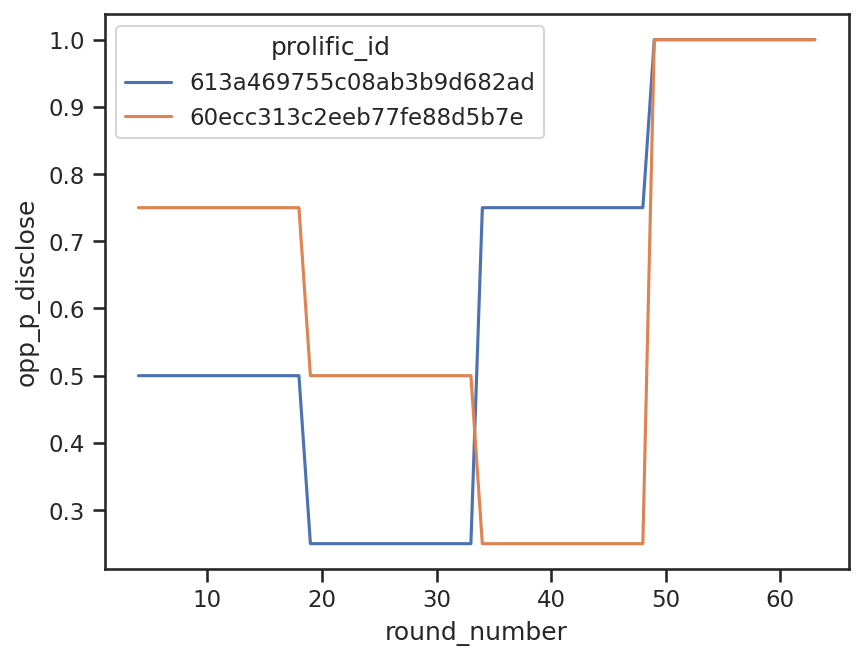

<Axes: xlabel='round_number', ylabel='opp_contribution'>

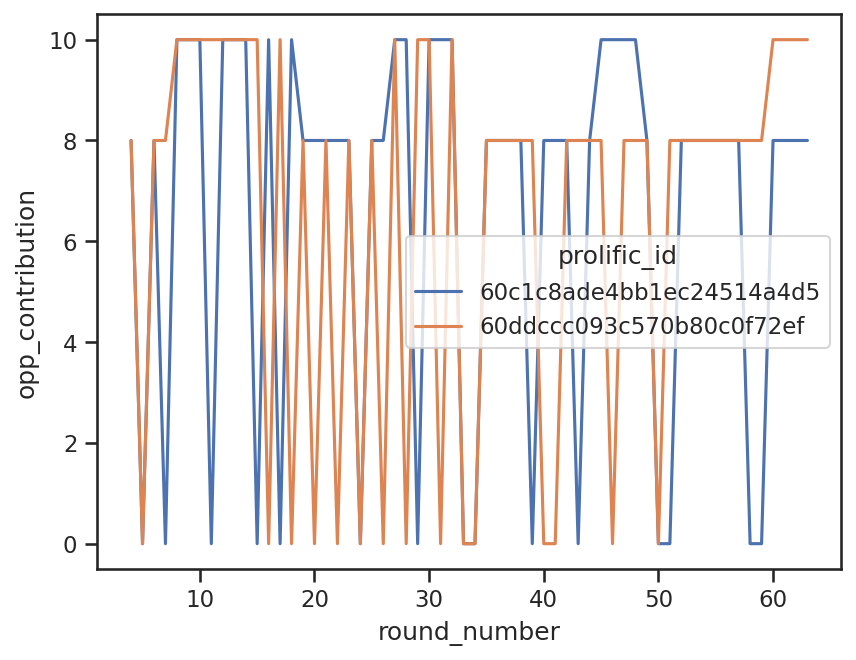

In [4]:

df = dfs[4].copy()
df = df[df.round_number>3]

# we manipulate the player multiplier (50/50)
fig1 = df.groupby('prolific_id').mean().multiplier.plot(kind='hist')
df.groupby('prolific_id', as_index=True).mean().multiplier.value_counts()
plt.show()

# we manipulate the opposant multiplier (50/50), also it is randomized across trials
fig2 = df.groupby('prolific_id').opp_multiplier.plot(kind='hist')
df.groupby('prolific_id').mean().opp_multiplier.value_counts()
plt.show()
sns.lineplot(x='round_number', y='opp_multiplier', hue='prolific_id', data=df[df.prolific_id.isin(df.prolific_id.sample(2))])
plt.show()

# we manipulate the opp p disclose
sns.lineplot(x='round_number', y='opp_p_disclose', hue='prolific_id', data=df[df.prolific_id.isin(df.prolific_id.sample(2))])
plt.show()

# we manipulate the opp contribution decision
sns.lineplot(x='round_number', y='opp_contribution', hue='prolific_id', data=df[df.prolific_id.isin(df.prolific_id.sample(2))])
# plot(x='round_number', y='opp_multiplier', legend=True)
# sns.lineplot(x='round_number', y='disclose', hue='multiplier', data=df,ci=68)

# Learning 

<Axes: xlabel='round_number', ylabel='norm_payoff'>

(0.0, 1.0)

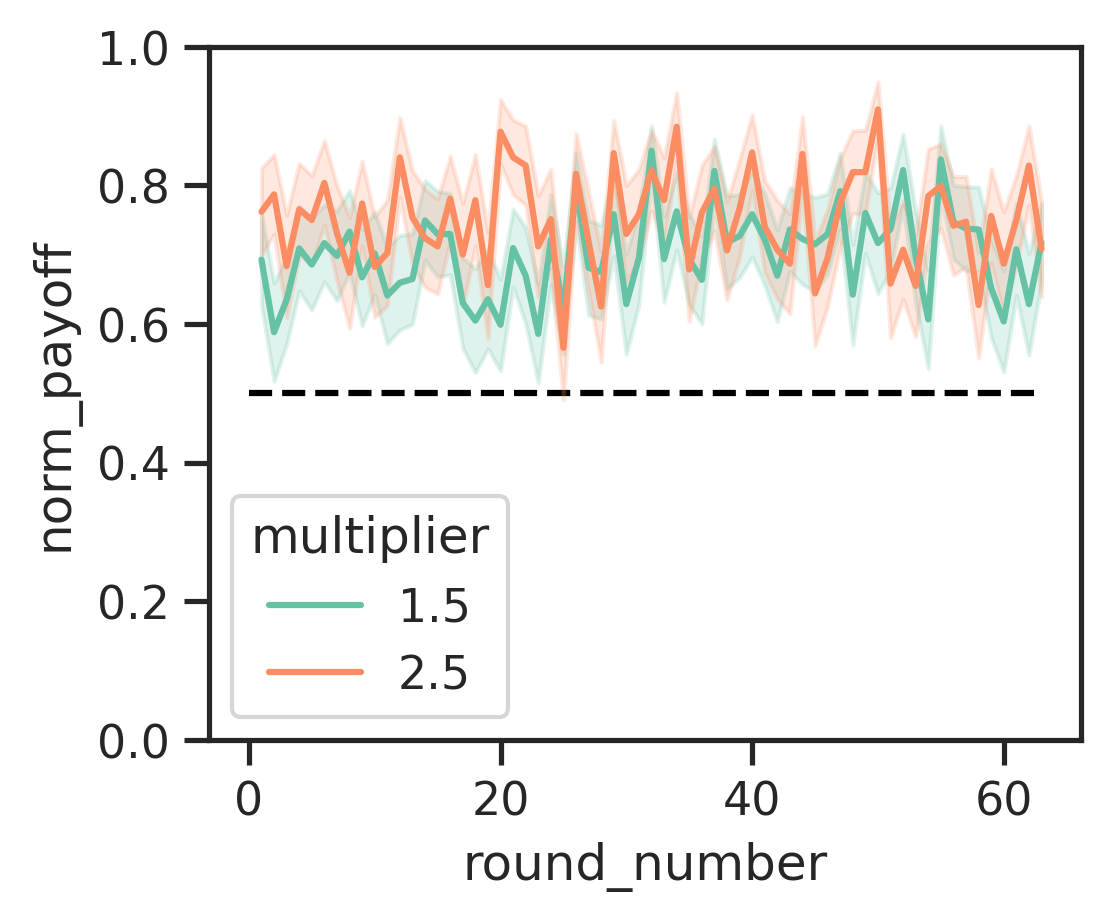

<Axes: xlabel='multiplier', ylabel='norm_payoff'>

(0.0, 1.0)

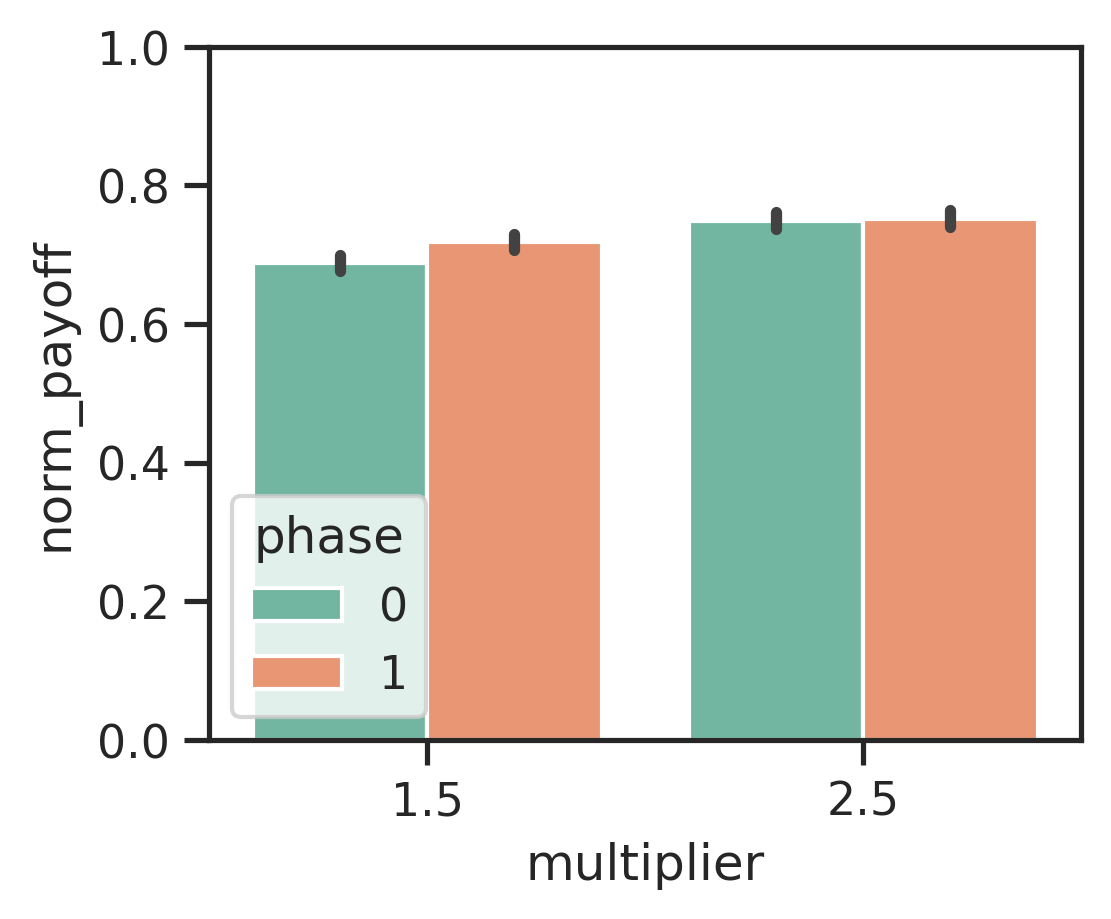

In [148]:
selected_exp = 3
df = dfs[selected_exp].copy()

sns.set_palette('Set2')

vd = 'norm_payoff'
plt.plot([0, 63], [.5, .5], zorder=0, color='black', linestyle='--')
sns.lineplot(x='round_number', y=vd, hue='multiplier', data=df, errorbar='se', palette='Set2')
plt.ylim(0,1)
plt.show()

df = df[df.round_number>3]
df['phase'] = 1
df.loc[(df.round_number<33), 'phase'] = 0

sns.barplot(x='multiplier', y=vd, hue='phase', data=df, errorbar='se', palette='Set2')
plt.ylim(0,1)
plt.show()


# Variables Corr

               multiplier opp_p_disclose opp_multiplier disclose contribution  \
multiplier            0.0            1.0            1.0      0.0          0.0   
opp_p_disclose        1.0            0.0            1.0   0.9275       0.2462   
opp_multiplier        1.0            1.0            0.0   0.8897       0.0006   
disclose              0.0         0.9275         0.8897      0.0       0.5451   
contribution          0.0         0.2462         0.0006   0.5451          0.0   
norm_payoff        0.1083         0.4963            0.0   0.6881       0.0906   

               norm_payoff  
multiplier          0.1083  
opp_p_disclose      0.4963  
opp_multiplier         0.0  
disclose            0.6881  
contribution        0.0906  
norm_payoff            0.0  


/tmp/ipykernel_130354/3324045528.py:23: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = x.corr()


<Axes: >

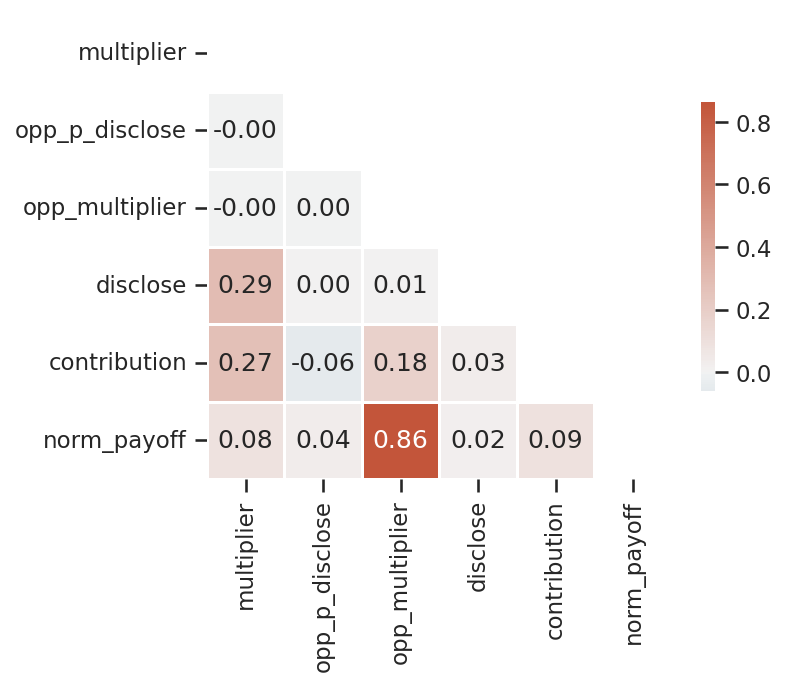

In [6]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues



selected_exp = 4
df = dfs[selected_exp].copy()
# df = df[df['round_number'] < 30]

x = df.groupby(
    ['prolific_id','multiplier','opp_p_disclose', 'opp_multiplier'], as_index=False
    )[['disclose', 'contribution', 'norm_payoff']].mean()

# y = df.groupby(['prolific_id', 'multiplier' ], as_index=False)['contribution'].mean()

# Compute the correlation matrix
corr = x.corr()
p = calculate_pvalues(x)

print(p)

# combining text with values
# formatted_text = (np.asarray(["{0}\n{1:.2f}".format(
    # text, data) for text, data in zip(p.flatten(), corr.flatten())])).reshape(3, 5)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=corr, fmt=".2f")

#
#

# Variables corrtable

,X,Y,method,alternative,n,r,CI95%,p-unc,p-corr,p-adjust,BF10,power
0,multiplier,disclose,pearson,two-sided,56,0.1549,"[-0.11, 0.4]",0.2542,1.0000,bonf,0.314,0.2085
1,multiplier,norm_contribution,pearson,two-sided,56,0.3754,"[0.12, 0.58]",0.0044,0.0653,bonf,8.758,0.8254
2,multiplier,contribution,pearson,two-sided,56,0.3754,"[0.12, 0.58]",0.0044,0.0653,bonf,8.758,0.8254
3,multiplier,norm_payoff,pearson,two-sided,56,0.4705,"[0.24, 0.65]",0.0003,0.0038,bonf,113.432,0.9630
4,multiplier,payoff,pearson,two-sided,56,0.9480,"[0.91, 0.97]",0.0000,0.0000,bonf,1.281e+25,1.0000
5,disclose,norm_contribution,pearson,two-sided,56,0.3707,"[0.12, 0.58]",0.0049,0.0737,bonf,7.875,0.8149
6,disclose,contribution,pearson,two-sided,56,0.3707,"[0.12, 0.58]",0.0049,0.0737,bonf,7.875,0.8149
7,disclose,norm_payoff,pearson,two-sided,56,0.0538,"[-0.21, 0.31]",0.6937,1.0000,bonf,0.18,0.0678
8,disclose,payoff,pearson,two-sided,56,0.1424,"[-0.13, 0.39]",0.2952,1.0000,bonf,0.284,0.1829
9,norm_contribution,contribution,pearson,two-sided,56,1.0000,"[1.0, 1.0]",0.0000,0.0000,bonf,inf,1.0000


,n,r,CI95%,p-val,BF10,power
pearson,56,0.3707,"[0.12, 0.58]",0.0049,7.875,0.8149


,n,r,CI95%,p-val,BF10,power
pearson,56,0.0150,"[-0.25, 0.28]",0.9126,0.168,0.0511


<Axes: xlabel='norm_contribution', ylabel='norm_payoff'>

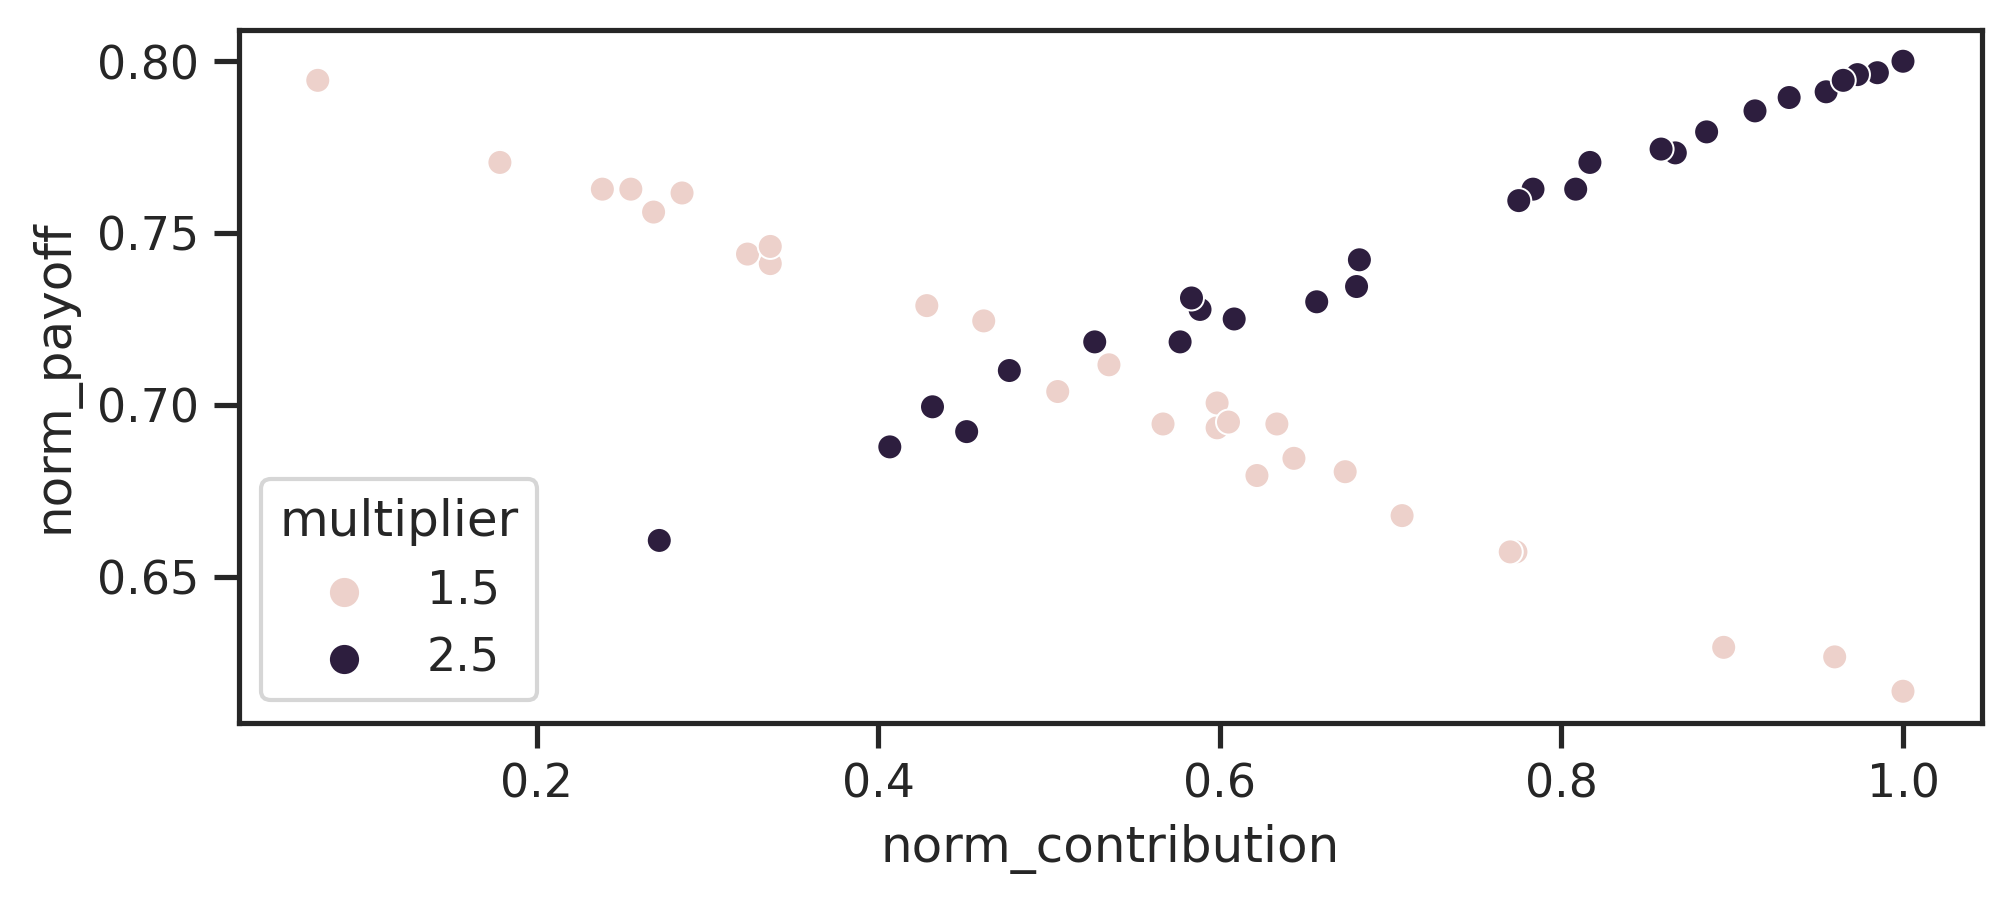

In [371]:
selected_exp = 3
df = dfs[selected_exp].copy()
pd.options.display.float_format = '{:.4f}'.format
x = df.groupby(['prolific_id', 'multiplier'], as_index=False)[['disclose', 'norm_contribution', 'contribution', 'norm_payoff', 'payoff']].mean()
pg.pairwise_corr(data=x, padjust='bonf')
pg.corr(x['disclose'], x['norm_contribution'])
pg.corr(x['norm_payoff'], x['norm_contribution'])
sns.scatterplot(x='norm_contribution', y='norm_payoff', hue='multiplier', data=x)

In [8]:
selected_exp = 4
df = dfs[selected_exp].copy()



(0.0, 1.0)

Text(170.64920370370376, 0.5, 'contribution')

Text(0.5, 101.99999999999999, 'p(disclose)')

Variable=norm_contribution


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      norm_contribution   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     7.119
Date:                Thu, 16 Mar 2023   Prob (F-statistic):            0.00121
Time:                        19:49:12   Log-Likelihood:                 12.426
No. Observations:                  30   AIC:                            -16.85
Df Residuals:                      26   BIC:                            -11.25
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.1656      0.153      1.080      0.290      -0.149       0.481
C(multiplier)[T.2.5]              0.4229      0.485      0.872      0.391      -0.574       1.420
disclose                          0.5732      0.169      3.398      0.002       0.226       0.920
disclose:C(multiplier)[T.2.5]    -0.2827      0.523     -0.540      0.594      -1.359       0.793
==============================================================================
Omnibus:                        3.236   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                2.877
Skew:                          -0.727   Prob(JB):                        0.237
Kurtosis:                       2.568   Cond. No.                         35.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      norm_contribution   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     10.82
Date:                Thu, 16 Mar 2023   Prob (F-statistic):           0.000355
Time:                        19:49:12   Log-Likelihood:                 12.259
No. Observations:                  30   AIC:                            -18.52
Df Residuals:                      27   BIC:                            -14.31
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1911      0.144      1.329      0.195      -0.104       0.486
C(multiplier)[T.2.5]     0.1632      0.062      2.611      0.015       0.035       0.291
disclose                 0.5438      0.158      3.451      0.002       0.220       0.867
==============================================================================
Omnibus:                        3.107   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.212   Jarque-Bera (JB):                2.747
Skew:                          -0.712   Prob(JB):                        0.253
Kurtosis:                       2.590   Cond. No.                         9.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      norm_contribution   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     12.27
Date:                Thu, 16 Mar 2023   Prob (F-statistic):            0.00157
Time:                        19:49:12   Log-Likelihood:                 8.8818
No. Observations:                  30   AIC:                            -13.76
Df Residuals:                      28   BIC:                            -10.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2217      0.158      1.407      0.170      -0.101       0.544
disclose       0.6007      0.172      3.502      0.002       0.249       0.952
==============================================================================
Omnibus:                        5.916   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                4.761
Skew:                          -0.969   Prob(JB):                       0.0925
Kurtosis:                       3.229   Cond. No.                         9.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,28.0,0.971613,0.0,NaN,NaN,NaN
1,27.0,0.775753,1.0,0.195860,6.638080,0.015770
2,26.0,0.767145,1.0,0.008608,0.291752,0.593697


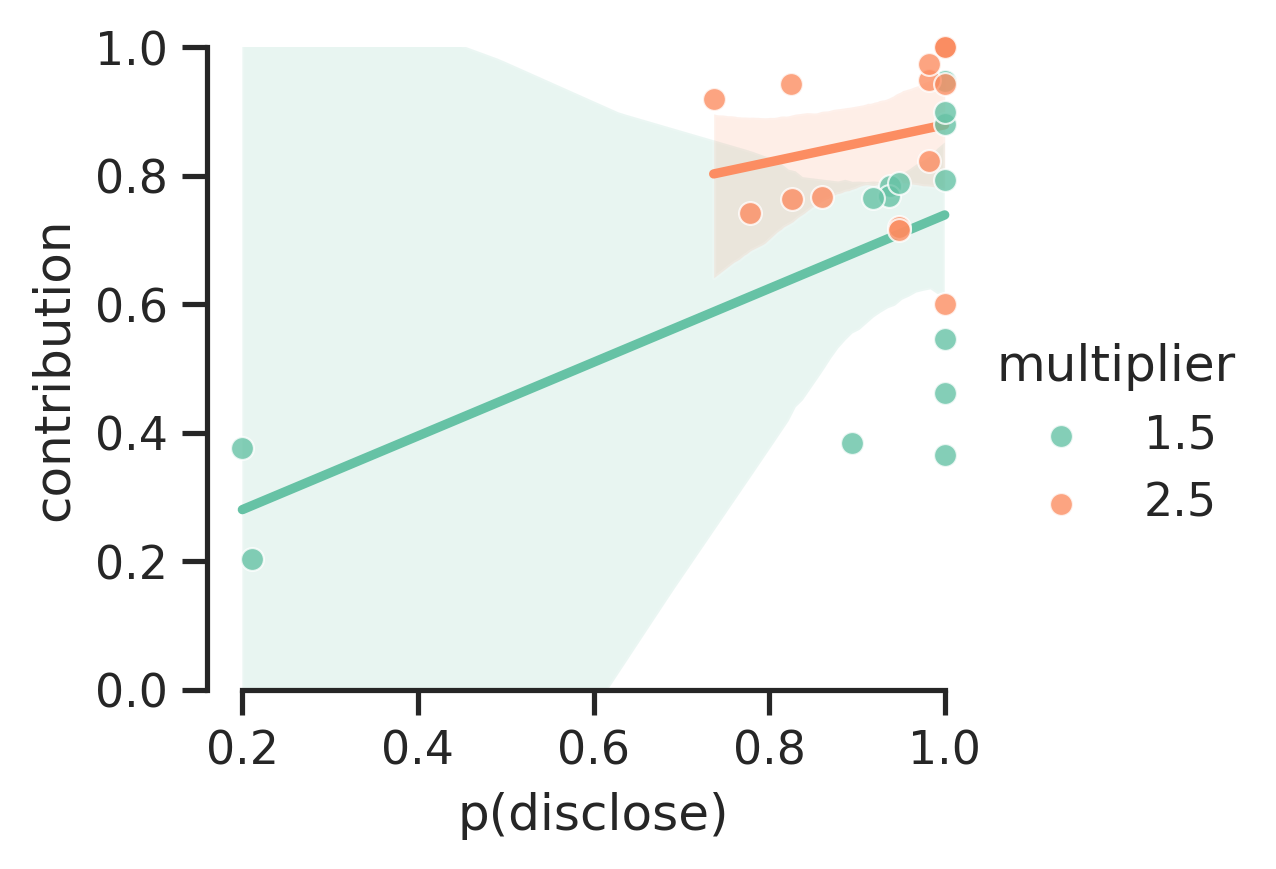

In [81]:
selected_exp = 1
df = dfs[selected_exp].copy()
sns.set(rc={'figure.figsize':(3.75, 3)})
sns.set_style('ticks')
sns.set_palette('Set2')

vd = 'norm_contribution'
x = df.groupby(['prolific_id', 'multiplier'], as_index=False)[['disclose', 'norm_contribution', 'norm_payoff', 'payoff']].mean()
sns.lmplot(
   x='disclose', hue='multiplier',
   y=vd,  data=x, scatter_kws={'clip_on': False, 'zorder': 10, 
    'edgecolor': 'white', 'lw': .5, 's': 30}, aspect=3.75/3, height=3)
plt.ylim(0,1)
plt.ylabel('contribution')
plt.xlabel('p(disclose)')
# remove left spines and set smart bounds
sns.despine(right=True, top=True, trim=True)

plt.savefig(f'fig/fig3_exp_{selected_exp}_{vd}.svg')
# plt.show()
#
#
# x = df.groupby(['prolific_id', 'multiplier'], as_index=False)[['disclose', 'norm_contribution', 'norm_payoff', 'payoff']].mean()
# x['norm_payoff'] = (x.norm_payoff-x.norm_payoff.min())/(x.norm_payoff.max()-x.norm_payoff.min())


print('Variable=norm_contribution')
model1 = smf.ols(formula='norm_contribution ~ disclose * C(multiplier)', data=x).fit()
model2 = smf.ols(formula='norm_contribution ~ disclose + C(multiplier)', data=x).fit()
model3 = smf.ols(formula='norm_contribution ~ disclose', data=x).fit()

model1.summary()
model2.summary()
model3.summary()


sma.anova_lm(model3,model2, model1, typ=1)

#print('Variable=norm_payoff')
#model1 = smf.ols(formula='norm_payoff ~ disclose * C(multiplier)', data=x).fit()
#model2 = smf.ols(formula='norm_payoff ~ disclose + C(multiplier)', data=x).fit()
#model3 = smf.ols(formula='norm_payoff ~ disclose', data=x).fit()
#
#model1.summary()
#
#sma.anova_lm(model3, model2, model1, typ=1)


Text(54.43622395833333, 0.5, 'social_welfare')

Text(0.5, 36.000000000000014, 'p(disclose)')

Variable=social_welfare


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         social_welfare   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     19.59
Date:                Wed, 08 Mar 2023   Prob (F-statistic):           5.41e-08
Time:                        20:05:52   Log-Likelihood:                -376.15
No. Observations:                 112   AIC:                             758.3
Df Residuals:                     109   BIC:                             766.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               29.8052      1.532     19.455      0.000      26.769      32.842
C(multiplier)[T.2.5]     7.8374      1.348      5.812      0.000       5.165      10.510
disclose                 2.7842      1.984      1.403      0.163      -1.148       6.716
==============================================================================
Omnibus:                      641.598   Durbin-Watson:                   3.659
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.177
Skew:                          -0.032   Prob(JB):                      0.00374
Kurtosis:                       1.454   Cond. No.                         4.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,110.0,7098.434265,0.0,NaN,NaN,NaN
1,109.0,5418.954216,1.0,1679.480049,33.589598,6.702467e-08
2,108.0,5400.000407,1.0,18.953809,0.379076,5.393934e-01


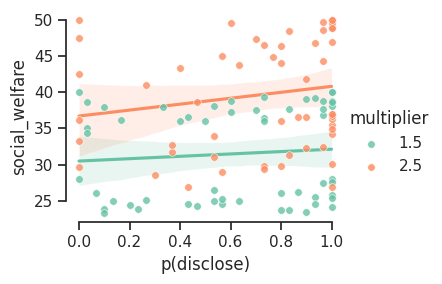

In [65]:
selected_exp = 3
df = dfs[selected_exp].copy()
sns.set(rc={'figure.figsize': (3.75, 3)})
sns.set_style('ticks')
sns.set_palette('Set2')

vd = 'social_welfare'
x = df.groupby(['prolific_id', 'multiplier', 'opp_multiplier'], as_index=False)[
    ['disclose', 'social_welfare', 'avg_norm_payoff', 'norm_contribution', 'norm_payoff', 'payoff']].mean()
x['avg_norm_payoff'] = (x.avg_norm_payoff-x.avg_norm_payoff.min()) / \
    (x.avg_norm_payoff.max()-x.avg_norm_payoff.min())
# for i in x.multiplier.unique():
sns.lmplot(
    x='disclose',
    y=vd, data=x, hue='multiplier', scatter_kws={'clip_on': False, 'zorder': 10,
                                                 'edgecolor': 'white', 'lw': .5, 's': 30}, aspect=3.75/3, height=3)
# plt.title('Opponent multiplier = '+str(i))

# plt.ylim(0, 1)
plt.ylabel(vd)
plt.xlabel('p(disclose)')
# remove left spines and set smart bounds
sns.despine(right=True, top=True, trim=True)

plt.savefig(f'fig/fig3_exp_wellfare_{selected_exp}_{vd}.svg')
# plt.show()
#
#
# x = df.groupby(['prolific_id', 'multiplier'], as_index=False)[['disclose', 'norm_contribution', 'norm_payoff', 'payoff']].mean()
# x['norm_payoff'] = (x.norm_payoff-x.norm_payoff.min())/(x.norm_payoff.max()-x.norm_payoff.min())

print(f'Variable={vd}')
model1 = smf.ols(formula=f'{vd} ~ disclose * C(multiplier)', data=x).fit()
model2 = smf.ols(formula=f'{vd} ~ disclose + C(multiplier)', data=x).fit()
model3 = smf.ols(formula=f'{vd} ~ disclose', data=x).fit()

# model2.summary()
model2.summary()

sma.anova_lm(model3, model2, model1, typ=1)


# Logistic fit

Optimization terminated successfully.
         Current function value: 0.612702
         Iterations 5


/home/getz/PycharmProjects/CovidGoodGameAnalysisLast/venv/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['skip_hessian']
  warnings.warn(msg, ValueWarning)
/home/getz/PycharmProjects/CovidGoodGameAnalysisLast/venv/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['skip_hessian']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               disclose   No. Observations:                 3528
Model:                          Logit   Df Residuals:                     3524
Method:                           MLE   Df Model:                            3
Date:                Thu, 23 Feb 2023   Pseudo R-squ.:                 0.04628
Time:                        14:57:46   Log-Likelihood:                -2161.6
converged:                       True   LL-Null:                       -2266.5
Covariance Type:            nonrobust   LLR p-value:                 3.256e-45
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -0.1141      0.081     -1.401      0.161      -0.274       0.046
C(multiplier)[T.2.5]                      -0.1023      0.144     -0.711      0.477      -0.385       0.180
norm_contribution                          1.0604      0.126      8.429      0.000       0.814       1.307
norm_contribution:C(multiplier)[T.2.5]     0.5129      0.203      2.531      0.011       0.116       0.910
==========================================================================================================
"""

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

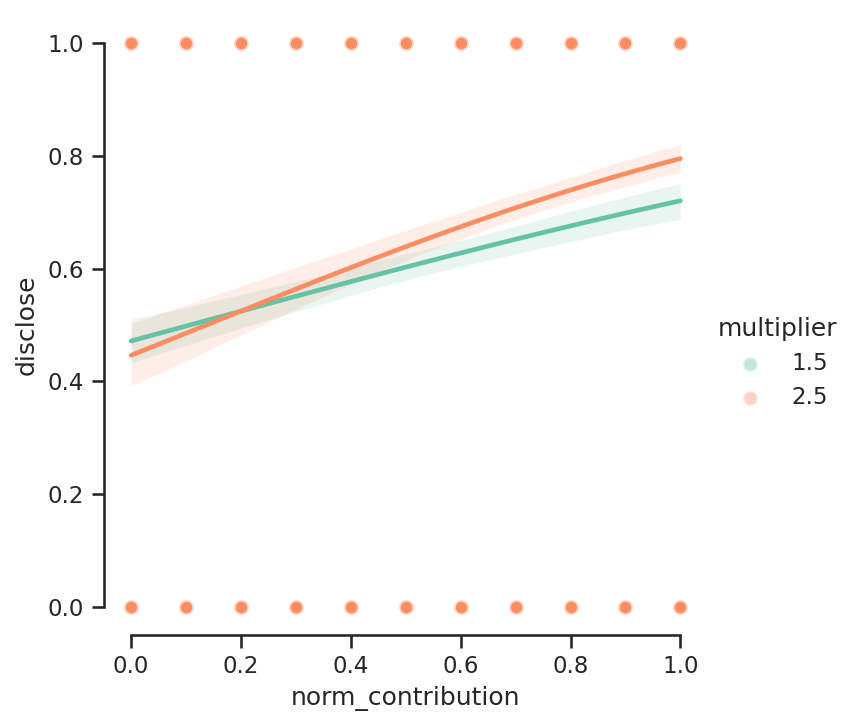

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               disclose   No. Observations:                 3528
Model:                          Logit   Df Residuals:                     3524
Method:                           MLE   Df Model:                            3
Date:                Thu, 23 Feb 2023   Pseudo R-squ.:                 0.04628
Time:                        14:57:51   Log-Likelihood:                -2161.6
converged:                       True   LL-Null:                       -2266.5
Covariance Type:            nonrobust   LLR p-value:                 3.256e-45
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -0.1141      0.081     -1.401      0.161      -0.274       0.046
C(multiplier)[T.2.5]                      -0.1023      0.144     -0.711      0.477      -0.385       0.180
norm_contribution                          1.0604      0.126      8.429      0.000       0.814       1.307
norm_contribution:C(multiplier)[T.2.5]     0.5129      0.203      2.531      0.011       0.116       0.910
==========================================================================================================
"""

In [10]:
selected_exp = 3
df = dfs[selected_exp].copy()
vd = 'disclose'

model1 = smf.logit(formula='disclose ~ norm_contribution * C(multiplier)', data=df, skip_hessian=True).fit()
# model2 = smf.ols(formula='norm_payoff ~ disclose + multiplier', data=x).fit()
model1.summary()

# fig, axs = plt.subplots(1, 2)
sns.set_palette('Set2')
plt.figure(figsize=(8, 6))
sns.lmplot(
   x='norm_contribution',
   y=vd, hue='multiplier', data=df, 
   logistic=True,
   scatter_kws=dict(clip_on=False, zorder=10, alpha=.4, edgecolor='white', lw=1.5, s=50))
# plt.ylim(.7,1)
# plt.xlim(-1,11)
# remove left spines and set smart bounds
sns.despine(right=True, top=True, trim=True)
# plt.gca().spines['bottom'].set_smart_bounds(True)
plt.show()

model1.summary()

/tmp/ipykernel_1107592/2231999340.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(


<Axes: xlabel='multiplier', ylabel='disclose'>

<Axes: xlabel='multiplier', ylabel='disclose'>

/tmp/ipykernel_1107592/2231999340.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(


<Axes: xlabel='multiplier', ylabel='disclose'>

Text(0, 0.5, 'average disclose')

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.152433   54   two-sided  0.254219  [-0.29, 0.08]  0.308001  0.469   

           power  
T-test  0.204841  


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,multiplier,0.607639,1,54,0.607639,1.328102,0.254219,0.024004,NaN
1,opp_p_disclose,0.010536,3,162,0.003512,0.217792,0.883951,0.004017,0.951041
2,Interaction,0.042758,3,162,0.014253,0.883881,0.450821,0.016105,NaN


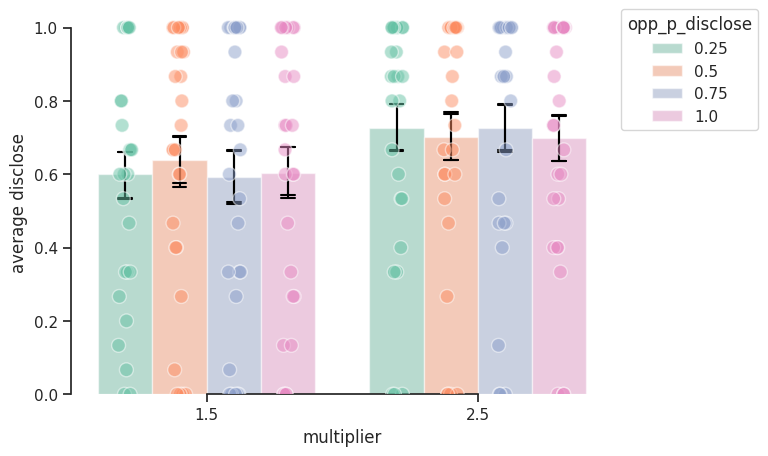

In [8]:
selected_exp = 3
df = dfs[selected_exp]

vi = 'opp_p_disclose'
vd = 'disclose'

fig, ax = plt.subplots(figsize=(7, 5))

df2 = df.groupby(['prolific_id', 'multiplier',
                    vi], as_index=False)[vd].mean()

sns.set_palette("Set2")

sns.barplot(
    x='multiplier',
    y=vd,
    hue=vi, data=df2, ci=68,
    edgecolor="white",
    errcolor="black",
    errwidth=1.5,
    capsize=0.05, 
    alpha=0.5, ax=ax, zorder=1)

# sns.pointplot()
sns.stripplot(
    x='multiplier',
     y=vd, hue=vi, data=df2, dodge=True,
              jitter=True, ax=ax, alpha=0.5, size=10, edgecolor='white', linewidth=1, zorder=5, palette='Set2')

sns.barplot(
   x='multiplier',
   y=vd,
   hue=vi, data=df2, ci=68,
   edgecolor="white",
   errcolor="black",
   errwidth=1.5,
   capsize=0.05,
   alpha=0., zorder=10)
#


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[4:], labels[8:], title=vi,
          bbox_to_anchor=(1, 1.02), loc='upper left')
sns.despine(right=True, top=True, trim=True)

plt.ylabel(f'average {vd}')

# plt.gca().spines['left'].set_smart_bounds(True)
# plt.gca().spines['bottom'].set_smart_bounds(True)

df3 = df.groupby(['prolific_id', 'multiplier'], as_index=False)[vd].mean()

r = pg.ttest(x=df3[df3['multiplier'] == 1.5][vd],
         y=df3[df3['multiplier'] == 2.5][vd])
# plt.ylim(.6, 1)
print(r)
pg.mixed_anova(data=df2, dv=vd, between="multiplier", within=vi, subject='prolific_id')


In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
df2 = df.groupby(['prolific_id', 'opp_p_disclose', 'multiplier'], as_index=False)['disclose'].mean()

sns.set_palette("crest")
sns.barplot(x='multiplier', y='disclose', hue='opp_p_disclose', data=df2, ci=None, 
    edgecolor="white",
    # errcolor="black",
    # errwidth=1.5,
    # capsize = 0.05,
    alpha=0.5, ax=ax)
# sns.pointplot(x='multiplier', y='disclose', hue='opp_p_disclose', data=df2, ci=68,')

sns.stripplot(x='multiplier',y='disclose', hue='opp_p_disclose', data=df2, dodge=True, jitter=True, ax=ax, alpha=0.5, size=10, edgecolor='white', linewidth=1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[4:], labels[4:], title='opp_p_disclose', bbox_to_anchor=(1, 1.02), loc='upper left')
sns.despine(right=True, top=True)

plt.ylabel('average disclosure')

plt.gca().spines['left'].set_smart_bounds(True)
plt.gca().spines['bottom'].set_smart_bounds(True)



/tmp/ipykernel_4825/1502728170.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df[(df.round_number>3) & (df.rt1!=-1)].groupby(['prolific_id',  'multiplier'], as_index=False).mean()


(25,)

<Axes: >

<Axes: xlabel='multiplier', ylabel='disclose'>

/tmp/ipykernel_4825/1502728170.py:29: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_4825/1502728170.py:29: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.stripplot(


<Axes: xlabel='multiplier', ylabel='disclose'>

Text(0, 0.5, 'p(disclose)')

Variable:  disclose
               T        dof alternative     p-val        CI95%   cohen-d  \
T-test -1.034416  13.698951   two-sided  0.318858  [-0.3, 0.1]  0.399241   

         BF10     power  
T-test  0.544  0.159493  


<Axes: >

<Axes: xlabel='multiplier', ylabel='norm_contribution'>

/tmp/ipykernel_4825/1502728170.py:61: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_4825/1502728170.py:61: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.stripplot(


<Axes: xlabel='multiplier', ylabel='norm_contribution'>

Text(0, 0.5, 'contribution')

<Axes: >

<Axes: xlabel='multiplier', ylabel='norm_payoff'>

/tmp/ipykernel_4825/1502728170.py:93: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_4825/1502728170.py:93: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.stripplot(


<Axes: xlabel='multiplier', ylabel='norm_payoff'>

Text(0, 0.5, 'payoff')

/tmp/ipykernel_4825/1502728170.py:119: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['prolific_id', 'multiplier'], as_index=False).mean()


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,multiplier,1.5,2.5,False,True,-21.974397,28.0,two-sided,3.386152e-19,6.41e+15,-8.023915


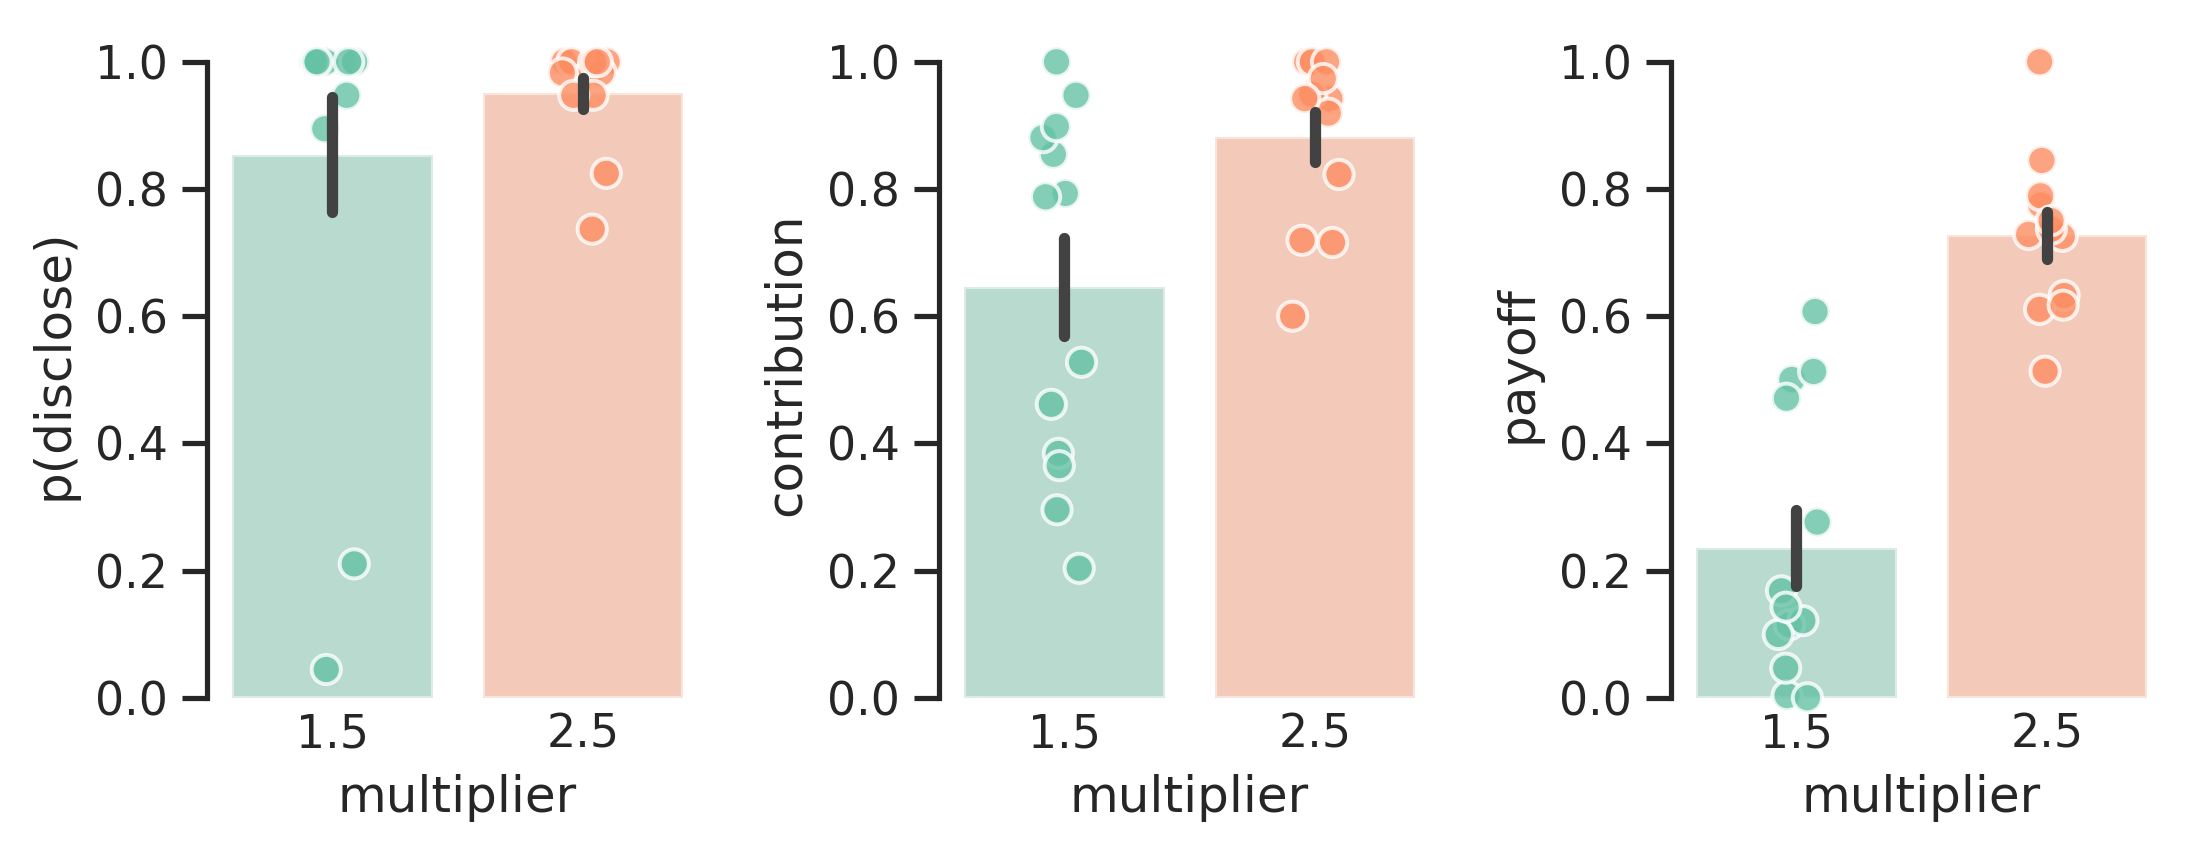

In [83]:
selected_exp = 1
df = dfs[selected_exp].copy()


sns.set({'figure.figsize': (7.5, 3), 'figure.dpi': 300})

#sns.set_palette("Set2")
blue = '#053F5C'
yellow = '#F7AD19'
# sns.set_palette(palette=[blue, yellow])
sns.set_palette('Set2')
palette = sns.color_palette()
sns.set_style("ticks")

df2 = df[(df.round_number>3) & (df.rt1!=-1)].groupby(['prolific_id',  'multiplier'], as_index=False).mean()
df2.prolific_id.unique().shape
df2['norm_payoff'] = (df2.norm_payoff-df2.norm_payoff.min())/(df2.norm_payoff.max()-df2.norm_payoff.min())

plt.subplot(1, 3, 1)
vd = 'disclose'
sns.barplot(x='multiplier', y=vd, data=df2, errorbar=('se'),
    edgecolor="white",
    # errcolor="black",
    # errwidth=1.5,
    # erralpha=0,
    # capsize = 0.05,
    alpha=0.5, zorder=0)

sns.stripplot(
    x='multiplier',
    y=vd,
    data=df2,
    alpha=0.8,
    size=7,
    linewidth=.95,
    edgecolor='white',
    zorder=1, palette=palette, clip_on=False)

plt.ylabel('p(disclose)')
sns.despine(trim=True, bottom=False)
plt.tick_params(axis='x', length=0)

    # plt.ylim(0, 1)
r = pg.ttest(x=df2[df2['multiplier'] == 1.5][vd],
    y=df2[df2['multiplier'] == 2.5][vd])
print('Variable: ', vd)
print(r)

# same plot for norm_contribution 
plt.subplot(1, 3, 2)
vd = 'norm_contribution'

sns.barplot(x='multiplier', y=vd, data=df2, errorbar=('se'),
    edgecolor="white",
    # errcolor="black",
    # errwidth=1.5,
    # erralpha=0,
    # capsize = 0.05,
    alpha=0.5, zorder=0)

sns.stripplot(
    x='multiplier',
    y=vd,
    data=df2,
    alpha=0.8,
    size=7,
    linewidth=.95,
    edgecolor='white',
    zorder=1, palette=palette, clip_on=False)

plt.ylabel('contribution')
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)
# same plot for norm_payoff 
    # plt.ylim(0, 1)
# r = pg.ttest(x=df2[df2['multiplier'] == 1.5][vd],
    # y=df2[df2['multiplier'] == 2.5][vd])
# print('Variable: ', vd)
# print(r)


plt.subplot(1, 3, 3)
vd = 'norm_payoff'

sns.barplot(x='multiplier', y=vd, data=df2, errorbar='se',
    edgecolor="white",
    # errcolor="black",
    # errwidth=1.5,
    # erralpha=0,
    # capsize = 0.05,
    alpha=0.5, zorder=0)

sns.stripplot(
    x='multiplier',
    y=vd,
    data=df2,
    # jitter=1,
    alpha=0.8,
    size=7,
    linewidth=.95,
    edgecolor='white',
    zorder=1, palette=palette, clip_on=False)


plt.ylabel('payoff')
# plt.ylim(0.6, 1.02)
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)

# r = pg.ttest(x=df2[df2['multiplier'] == 1.5][vd],
    # y=df2[df2['multiplier'] == 2.5][vd])
# print('Variable: ', vd)
# print(r)


plt.tight_layout()
plt.savefig(f'fig/fig2_exp_{selected_exp}.svg')

df2 = df.groupby(['prolific_id', 'multiplier'], as_index=False).mean()
pg.pairwise_tests(data=df2, dv='payoff', between='multiplier',  padjust='bonferroni', effsize='cohen')


/tmp/ipykernel_4825/2890415676.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = full.groupby(['exp', 'prolific_id'], as_index=False).mean()


<Axes: xlabel='exp', ylabel='disclose'>

<Axes: xlabel='exp', ylabel='disclose'>

Text(0, 0.5, 'disclose')

Variable:  disclose
               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.147913   24   two-sided  0.042027  [-0.33, -0.01]  0.842481  1.838   

           power  
T-test  0.540497  


,Source,SS,DF,MS,F,p-unc,np2
0,exp,18.930922,4.0,4.732731,83.573358,1.184047e-40,0.640049
1,multiplier,0.535744,1.0,0.535744,9.460483,2.412588e-03,0.047911
2,exp * multiplier,0.109197,4.0,0.027299,0.482065,7.488879e-01,0.010153
3,Residual,10.646375,188.0,0.056630,NaN,NaN,NaN


,Contrast,exp,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,exp,-,0.0,1.0,False,True,0.422093,45.349290,two-sided,6.749515e-01,1.000000e+00,bonferroni,0.273,0.109053
1,exp,-,0.0,2.0,False,True,18.955736,47.474802,two-sided,8.756012e-24,8.756012e-23,bonferroni,2.944e+24,4.872220
2,exp,-,0.0,3.0,False,True,5.121833,74.071525,two-sided,2.320130e-06,2.320130e-05,bonferroni,8473.492,0.920955
3,exp,-,0.0,4.0,False,True,18.412858,71.677319,two-sided,6.948839e-29,6.948839e-28,bonferroni,9.9e+26,3.826322
4,exp,-,1.0,2.0,False,True,14.607201,58.000000,two-sided,4.312458e-21,4.312458e-20,bonferroni,5.984e+17,3.771563
5,exp,-,1.0,3.0,False,True,4.042029,82.995071,two-sided,1.179136e-04,1.179136e-03,bonferroni,192.422,0.789568
6,exp,-,1.0,4.0,False,True,14.009777,66.601752,two-sided,1.562262e-21,1.562262e-20,bonferroni,1.501e+19,3.215795
7,exp,-,2.0,3.0,False,True,-8.781571,83.861580,two-sided,1.653625e-13,1.653625e-12,bonferroni,3.135e+10,-1.687659
8,exp,-,2.0,4.0,False,True,-0.896433,69.245764,two-sided,3.731276e-01,1.000000e+00,bonferroni,0.342,-0.202775
9,exp,-,3.0,4.0,False,True,8.144780,95.843437,two-sided,1.415281e-12,1.415281e-11,bonferroni,5.382e+09,1.558788


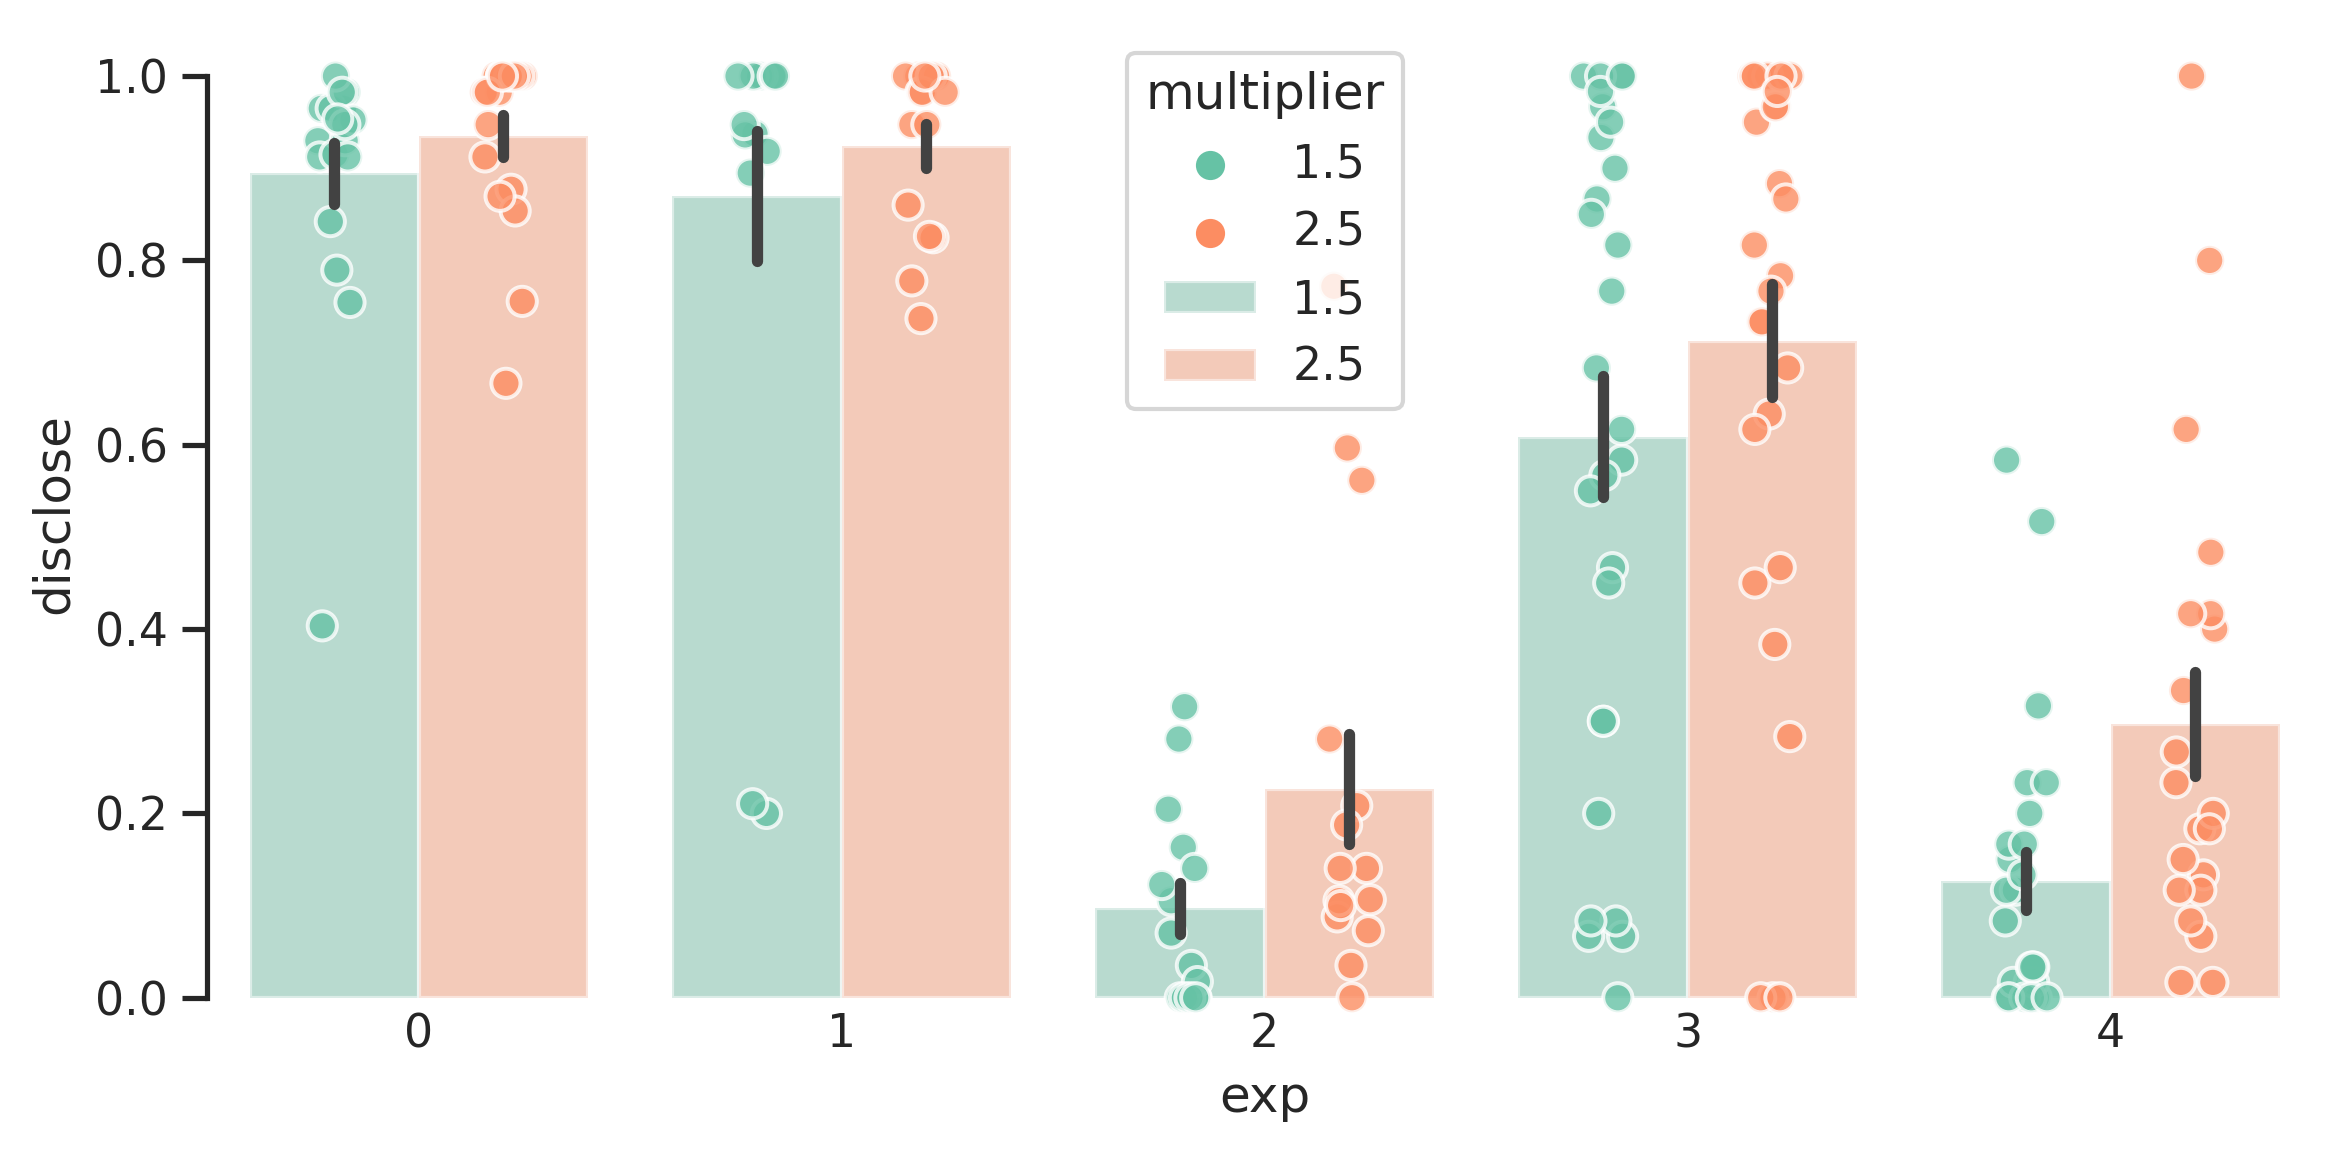

In [78]:
vd = 'disclose'

sns.set({'figure.figsize': (8, 4), 'figure.dpi': 300})
sns.set_style("ticks")

df2 = full.groupby(['exp', 'prolific_id'], as_index=False).mean()

sns.barplot(x='exp', y=vd, data=df2, errorbar='se',
    edgecolor="white",
    hue='multiplier',
    # errcolor="black",
    # errwidth=1.5,
    # erralpha=0,
    # capsize = 0.05,
    alpha=0.5, zorder=0, palette='Set2', hue_order=[1.5, 2.5])

sns.stripplot(
    x='exp',
    y=vd,
    data=df2,
    hue='multiplier',
    # jitter=1,
    dodge=True,
    alpha=0.8,
    size=7,
    linewidth=.95,
    edgecolor='white',
    zorder=1, palette='Set2', clip_on=False, hue_order=[1.5, 2.5])


plt.ylabel(vd)
# plt.ylim(0.6, 1.02)
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)

# r = pg.ttest(x=df2[vd][df2['exp'] == 3],
    # y=df2[vd][df2['exp'] == 4])
print('Variable: ', vd)
print(r)

pg.anova(data=df2, dv=vd, between=['exp', 'multiplier'])
pg.pairwise_tests(data=df2, dv=vd, between=['exp', 'multiplier'], padjust='bonferroni', effsize='cohen')


plt.tight_layout()

<Axes: >

/tmp/ipykernel_4825/29732696.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['prolific_id', 'multiplier'], as_index=False).mean()


<Axes: xlabel='multiplier', ylabel='norm_contribution'>

<Axes: xlabel='multiplier', ylabel='norm_contribution'>

Variable:  norm_contribution
               T  dof alternative    p-val          CI95%   cohen-d   BF10  \
T-test -1.317432   22   two-sided  0.20125  [-0.34, 0.08]  0.537839  0.695   

           power  
T-test  0.242713  


Text(0, 0.5, 'contribution')

Variable:  norm_contribution


,Source,SS,DF,MS,F,p-unc,np2
0,discloser_type,0.183670,1.0,0.183670,4.823587,0.040032,0.194315
1,multiplier,0.447400,1.0,0.447400,11.749736,0.002665,0.370074
2,discloser_type * multiplier,0.101918,1.0,0.101918,2.676602,0.117473,0.118034
3,Residual,0.761548,20.0,0.038077,NaN,NaN,NaN


<Axes: >

/tmp/ipykernel_4825/29732696.py:62: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['prolific_id', 'multiplier'], as_index=False).mean()


<Axes: xlabel='multiplier', ylabel='norm_payoff'>

<Axes: xlabel='multiplier', ylabel='norm_payoff'>

Variable:  norm_payoff
               T  dof alternative    p-val         CI95%   cohen-d   BF10  \
T-test  0.465299   22   two-sided  0.64629  [-0.2, 0.31]  0.189957  0.404   

           power  
T-test  0.073011  


Text(0, 0.5, 'payoff')

Variable:  norm_payoff


,Source,SS,DF,MS,F,p-unc,np2
0,discloser_type,0.003041,1.0,0.003041,0.098688,0.756663,0.004910
1,multiplier,1.327948,1.0,1.327948,43.091355,0.000002,0.682999
2,discloser_type * multiplier,0.014934,1.0,0.014934,0.484590,0.494362,0.023656
3,Residual,0.616341,20.0,0.030817,NaN,NaN,NaN


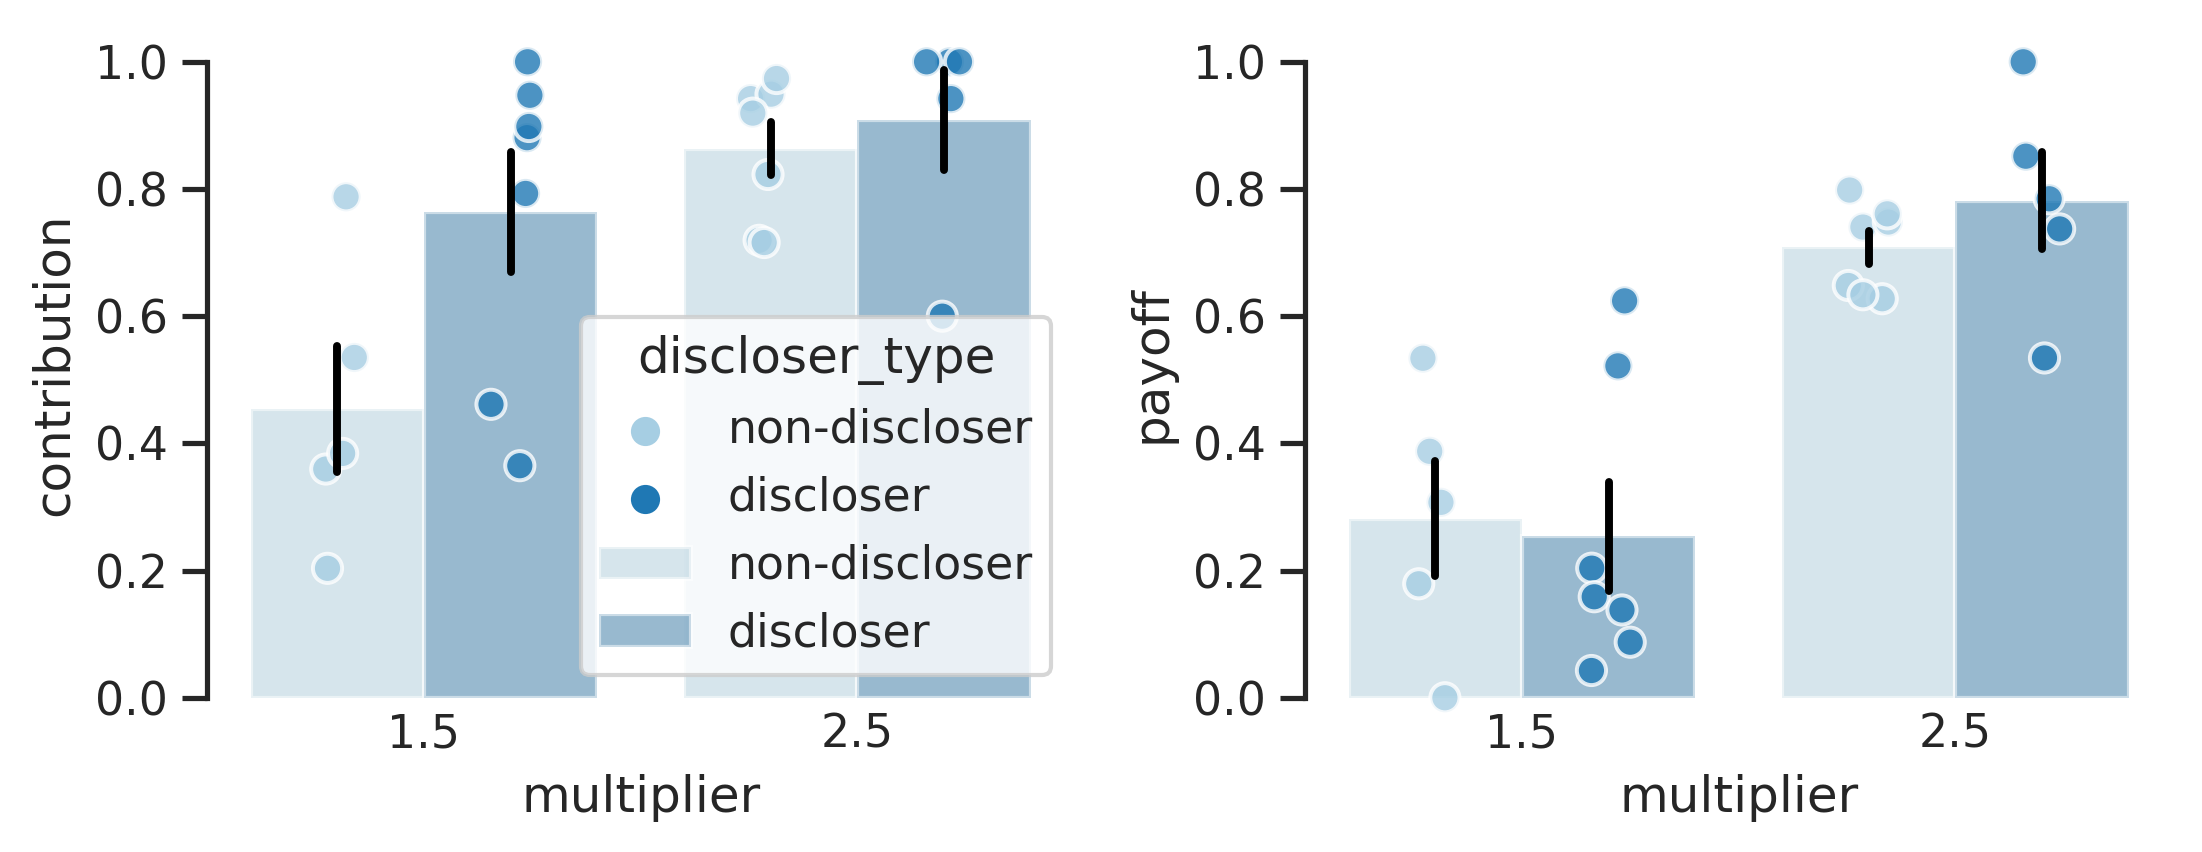

In [73]:
selected_exp = 1
df = dfs[selected_exp].copy()
# df['norm_payoff'] = (df.norm_payoff-df.norm_payoff.min())/(df.norm_payoff.max()-df.norm_payoff.min())

sns.set({'figure.figsize':(7.5, 3), 'figure.dpi': 300})
sns.set_style('ticks')
sns.set_palette("Paired")

# --------------------------------------------------------------------------------------------------------
# Figure contribution
#---------------------------------------------------------------------------------------------------------
plt.subplot(1, 2, 1)
vd = 'norm_contribution'

df2 = df.groupby(['prolific_id', 'multiplier'], as_index=False).mean()
# df2['norm_payoff'] = (df2.norm_payoff-df2.norm_payoff.min())/(df2.norm_payoff.max()-df2.norm_payoff.min())
med = df2.disclose.median()

df2['discloser_type'] = df2['disclose'].apply(lambda x: 'discloser' if x > med else 'non-discloser')

sns.barplot(x='multiplier', y=vd, data=df2, errorbar="se",
            edgecolor="white",
            hue='discloser_type',
            errcolor="black",
            errwidth=1.9,
            capsize = 0.00,
            alpha=0.5, zorder=0, hue_order=['non-discloser', 'discloser'])

sns.stripplot(
    x='multiplier',
    y=vd,
    hue='discloser_type',
    data=df2,
    dodge=True,
    jitter=True,
    alpha=0.8,
    size=7,
    linewidth=.95,
    edgecolor='white',
    zorder=1, hue_order=['non-discloser', 'discloser'], clip_on=False)

r = pg.ttest(x=df2[df2['discloser_type'] == 'non-discloser'][vd],
            y=df2[df2['discloser_type'] == 'discloser'][vd])
print('Variable: ', vd)
print(r)
# break
plt.ylabel('contribution')
# plt.ylim(0.6, .8)
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)
print('Variable: ', vd)
pg.anova(data=df2, dv=vd, between=['discloser_type', 'multiplier'])
# plt.legend((), (), frameon=False)

# --------------------------------------------------------------------------------------------------------
# Figure payoff
#---------------------------------------------------------------------------------------------------------

plt.subplot(1, 2, 2)
vd = 'norm_payoff'

df2 = df.groupby(['prolific_id', 'multiplier'], as_index=False).mean()
df2['norm_payoff'] = (df2.norm_payoff-df2.norm_payoff.min())/(df2.norm_payoff.max()-df2.norm_payoff.min())
med = df2.disclose.median()

df2['discloser_type'] = df2['disclose'].apply(lambda x: 'discloser' if x > med else 'non-discloser')

sns.barplot(x='multiplier', y=vd, data=df2, errorbar="se",
            edgecolor="white",
            hue='discloser_type',
            errcolor="black",
            errwidth=1.9,
            capsize = 0.00,
            alpha=0.5, zorder=0, hue_order=['non-discloser', 'discloser'])

sns.stripplot(
    x='multiplier',
    y=vd,
    hue='discloser_type',
    data=df2,
    dodge=True,
    jitter=True,
    alpha=0.8,
    size=7,
    linewidth=.95,
    edgecolor='white',
    zorder=1, hue_order=['non-discloser', 'discloser'], clip_on=False)

r = pg.ttest(x=df2[df2['discloser_type'] == 'non-discloser'][vd],
            y=df2[df2['discloser_type'] == 'discloser'][vd])
print('Variable: ', vd)
print(r)
# break
plt.ylabel('payoff')
# plt.ylim(0.6, .8)
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)

print('Variable: ', vd)
pg.anova(data=df2, dv=vd, between=['discloser_type', 'multiplier'])
plt.legend((), (), frameon=False)

plt.tight_layout()

plt.savefig(f'fig/fig2_interaction_exp{selected_exp}.svg')

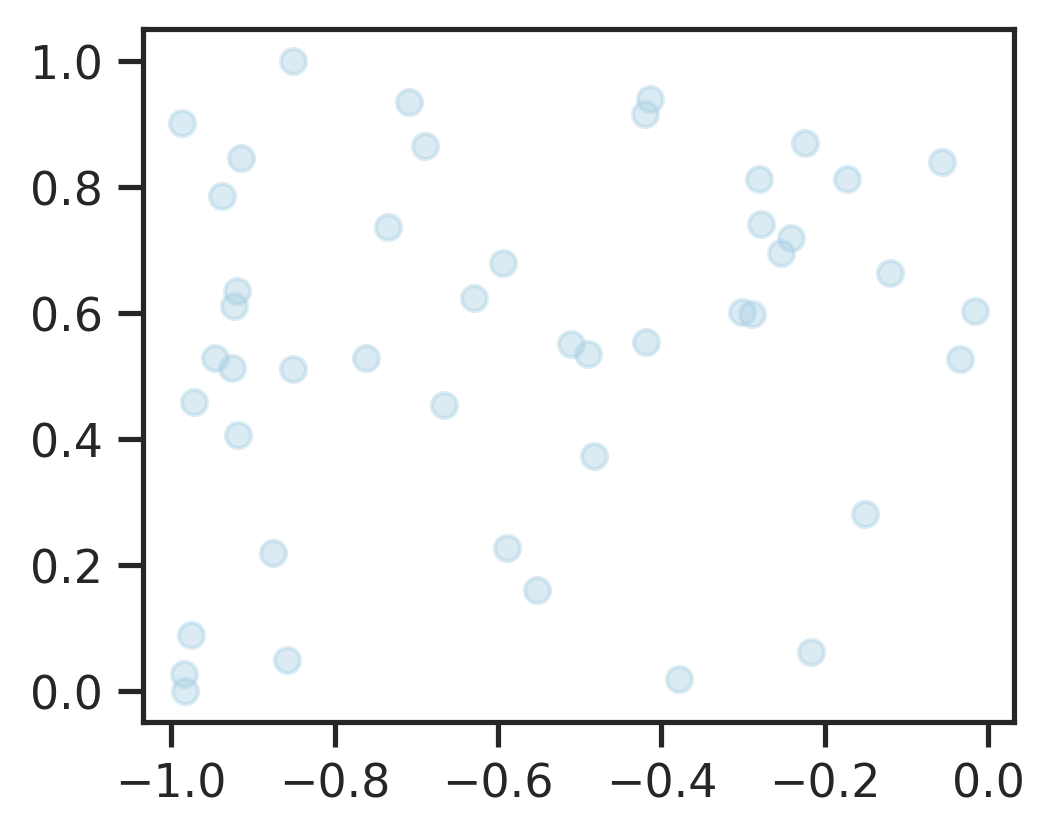

In [227]:
s = (df.groupby('prolific_id').norm_payoff.mean()-df.groupby('prolific_id').norm_payoff.mean().min())/(df.groupby('prolific_id').norm_payoff.mean().max()-df.groupby('prolific_id').norm_payoff.mean().min())
plt.scatter(x=[0, ] * len(s) + (np.random.random(size=len(s)) -1), y=s, alpha=0.4)